# Deleterious variants

This analysis aimed to answer the following research question: 
1. Which variants identified in African populations have deleterious effect prediction scores and are thus most likely to contribute to disease?

To achieve this, the following steps were performed:

1. Data on the impact of variants on gene functionality and protein translation (consequences), predictions of potential harm (effect predictions), and variant counts within African populations were loaded and merged into a single DataFrame for ease of downstream analysis.
2. The distribution of variants classified as potentially harmful (deleterious) versus non-harmful (neutral) within the genes of interest was depicted using a stacked bar plot.
3. Variants were arranged in a tabular format based on their level of predicted potential harm, with those having the highest deleterious predictions receiving the greatest level of potential harm.

## Imports

Import relevant libraries and packages

In [58]:
import os
import sys
import warnings

from dotenv import load_dotenv

load_dotenv()

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
if PROJECT_ROOT not in sys.path:
    os.chdir(PROJECT_ROOT + "/Notebooks")
    sys.path.append(PROJECT_ROOT)

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import Utils.constants as constants
import Utils.functions as functions

Turn off warning notifications

In [59]:
warnings.filterwarnings("ignore")

Set plot parameters

In [60]:
plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.MEDIUM_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

## Data loading

Import the processed variant effect data from the `Data/Processed/Variant_effects.csv` file. This file includes the following information:

* `CHROM`: Chromosome number where the variant is located.
* `POS`: Genomic position of the variant.
* `REF`: Reference allele (original allele).
* `ALT`: Alternate allele (mutated allele).
* `GENE`: Name of the gene affected by the variant.
* `POLYPHEN_PRED`: PolyPhen prediction category (e.g., benign, possibly damaging).
* `POLYPHEN_SCORE`: PolyPhen score indicating the probability of impact.
* `SIFT_PRED`: SIFT prediction category (e.g., tolerated, deleterious).
* `SIFT_SCORE`: SIFT score indicating the impact on protein function.
* `CADD_RAW_SCORE`: Raw CADD score assessing the variant's potential impact.
* `CADD_PHRED_SCORE`: CADD PHRED score providing a normalized rank of the variant's impact.

In [61]:
vep_data = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "Variant_effects.csv",
    )
)

vep_data.head(5)

,CHROM,POS,REF,ALT,GENE,POLYPHEN_PRED,POLYPHEN_SCORE,SIFT_PRED,SIFT_SCORE,CADD_RAW_SCORE,CADD_PHRED_SCORE,ID
0,13,110148882,C,CT,COL4A1,NaN,NaN,NaN,NaN,-0.437825,0.160,110148882_C_CT
1,13,110148891,C,G,COL4A1,NaN,NaN,NaN,NaN,-0.227221,0.446,110148891_C_G
2,13,110148917,C,G,COL4A1,NaN,NaN,NaN,NaN,0.269936,3.938,110148917_C_G
3,13,110148920,G,C,COL4A1,NaN,NaN,NaN,NaN,0.530972,6.825,110148920_G_C
4,13,110148959,A,G,COL4A1,NaN,NaN,NaN,NaN,1.380228,14.950,110148959_A_G


Import the processed variant consequence data from the `Data/Processed/Variant_consequences.csv` file. This file includes the following information:

* `CHROM`: Chromosome number where the variant is located.
* `POS`: Genomic position of the variant.
* `REF`: Reference allele (original allele).
* `ALT`: Alternate allele (mutated allele).
* `TYPE`: Type of genetic variant (e.g., SNP, insertion, deletion).
* `CONSEQUENCE_CLASSIFICATION`: Classification of the variant's impact on the gene (e.g., downstream, upstream).
* `CONSEQUENCE`: Specific consequence of the variant (e.g., missense, nonsense, synonymous).
* `GENE`: Name of the gene affected by the variant.
* `ID`: The unique variant identifier.

In [62]:
consequence_data = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "Variant_consequences.csv",
    )
)

consequence_data.head(5)

,CHROM,POS,REF,ALT,TYPE,CONSEQUENCE_CLASSIFICATION,CONSEQUENCE,GENE,ID
0,13,110148882,C,CT,INS,downstream,downstream,COL4A1,110148882_C_CT
1,13,110148891,C,G,SNV,downstream,downstream,COL4A1,110148891_C_G
2,13,110148917,C,G,SNV,downstream,downstream,COL4A1,110148917_C_G
3,13,110148920,G,C,SNV,downstream,downstream,COL4A1,110148920_G_C
4,13,110148959,A,G,SNV,downstream,downstream,COL4A1,110148959_A_G


Import the processed African variant count data from the `Data/Processed/IH_allele_counts.csv` file. This file includes the following information:

* `ID`: A unique variant identifier.
* `VAR_NAME`: The non-unique name of the variant.
* `POS`: The nucleotide position at which the genetic variant is located within the genome.
* `ALT` and `REF`: An allele refers to the different forms of a specific variant that can exist at a particular genetic position. For each variant, there are two alleles, the normal form known as the reference allele (REF), and the altered form known as the alternate allele (ALT). These alleles define the genetic variation at a given position.
* `GENE`: The gene in which the variant is located.
* `SUB_POP`: The African ethnolinguistic subpopulation from which the genetic data sample originated.
* `IH_ALT_CTS`: This shows how many times each genetic variant's alternate allele (ALT) appears in all the samples of a population.
* `IH_TOTAL_CTS`: This provides the overall count of all genetic variants' alleles (both REF and ALT) mentioned in the data.
* `IH_REF_CTS`: This shows how many times each genetic variant's reference allele form (REF) appears in all the samples of a population.
* `REG`: The regional classification of the sample's ethnolinguistic group. The possible regions are:
  - Central Africa (CA)
  - Southern Africa (SA)
  - Eastern Africa (EA)
  - Western Africa (WA)
* `IH_AF`: The frequency of the variant's alternate allele in all samples of the population.
* `VARIANT_TYPE`: The type of variant. The possible types are:
    - INDEL
    - SNP

In [63]:
ih_afr = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "IH_allele_counts.csv",
    )
)

ih_afr.head(5)

,ID,VAR_NAME,VARIANT_TYPE,CHROM,POS,REF,ALT,GENE,SUB_POP,REG,IH_REF_CTS,IH_ALT_CTS,IH_TOTAL_CTS,IH_AF
0,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,Bantu Kenya,EA,20,0,20,0.0
1,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,Yoruba,WA,276,0,276,0.0
2,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,San,SA,12,0,12,0.0
3,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,Mende,WA,166,0,166,0.0
4,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,Mbuti Pygmy,CA,24,0,24,0.0


## Data merging

Merge the data from all sources into a single DataFrame to facilitate ease of downstream analysis.

In [64]:
# Select aggregated variant count and frequency data for Recent Africans.
# Remove variants with an alternate allele count of 0. These variants are not present in Recent Africans.
ih_afr_subpops = ih_afr[
    (ih_afr["REG"] == "Recent African") & (ih_afr["IH_ALT_CTS"] > 0)
]

# Merge the African variant allele count and variant effect data
merged_data = ih_afr_subpops.merge(
    vep_data,
    how="left",
    on=["CHROM", "ID", "REF", "ALT", "POS", "GENE"],
)

# Include the variant consequence data
merged_data = merged_data.merge(
    consequence_data,
    how="left",
    on=["CHROM", "ID", "REF", "ALT", "POS", "GENE"],
)

# Drop unnecessary columns
merged_data.drop(
    columns=[
        "VARIANT_TYPE",
        "SUB_POP",
        "REG",
        "IH_REF_CTS",
        "IH_ALT_CTS",
        "IH_TOTAL_CTS",
        "POLYPHEN_PRED",
        "POLYPHEN_SCORE",
        "SIFT_PRED",
        "SIFT_SCORE",
        "CADD_RAW_SCORE",
    ],
    inplace=True,
)

merged_data.head(5)

,ID,VAR_NAME,CHROM,POS,REF,ALT,GENE,IH_AF,CADD_PHRED_SCORE,TYPE,CONSEQUENCE_CLASSIFICATION,CONSEQUENCE
0,110148891_C_G,rs552586867,13,110148891,C,G,COL4A1,0.000820,0.446,SNV,downstream,downstream
1,110148917_C_G,rs59409892,13,110148917,C,G,COL4A1,0.097541,3.938,SNV,downstream,downstream
2,110149176_T_A,rs546124548,13,110149176,T,A,COL4A1,0.000820,12.630,SNV,3prime_utr,3_prime_UTR
3,110149349_G_A,rs139916479,13,110149349,G,A,COL4A1,0.004098,3.798,SNV,3prime_utr,3_prime_UTR
4,110149494_C_T,rs552877576,13,110149494,C,T,COL4A1,0.000820,15.020,SNV,3prime_utr,3_prime_UTR


## Analysis and Visualisation

### Distribution of deleterious variants in the genes of interest

Classify variants based on CADD Phred Score. Variants with a CADD Phred Score of of 10 or more are within the to 10% of deleterious variants and will be classified as 'Deleterious', while variants with lower CADD Phred Scores will be classified as 'Neutral'. Determine the number of variants within each gene of interest that are classified as Deleterious.

In [78]:
# Classify variants based on CADD Phred Score
merged_data["CADD_PHRED_CATEGORY"] = np.where(
    merged_data["CADD_PHRED_SCORE"] >= 10, "Deleterious", "Neutral"
)

# Group by gene and CADD Phred category
pathogenicity_grouped = (
    merged_data.drop_duplicates(subset=["ID"])
    .groupby(["GENE", "CADD_PHRED_CATEGORY"])
    .count()
    .reset_index()
    .rename(columns={"ID": "COUNT"})[["GENE", "CADD_PHRED_CATEGORY", "COUNT"]]
)

# Transform the data to enhance readability
pathogenicity_pivot = pd.pivot(
    pathogenicity_grouped,
    index=["GENE"],
    columns=["CADD_PHRED_CATEGORY"],
    values=["COUNT"],
)
pathogenicity_pivot.columns = pathogenicity_pivot.columns.droplevel()

print(f"Deleterious variant count per gene:\n{pathogenicity_pivot}")
print(f"\nTotal deleterious variant count: {pathogenicity_pivot.Deleterious.sum()}")
print(
    f"\nPercentage of deleterious variants: {pathogenicity_pivot.Deleterious.sum() / merged_data.ID.nunique() * 100}%"
)

Deleterious variant count per gene:
CADD_PHRED_CATEGORY  Deleterious  Neutral
GENE                                     
AGT                           21      480
AP4B1                         37      116
CARD8                         42     2055
CAT                           41      578
COL4A1                       102     3936
IL10                          22       97
IL1B                           7      103
IL6                           16      101
MTHFR                         48      433
NOS3                          62      481
OLIG2                         12       46
TNF                            7       27

Total deleterious variant count: 417

Percentage of deleterious variants: 4.7012401352874855%


Generate a stacked barplot visually representing the distribution of variants classified as potentially harmful or neutral.

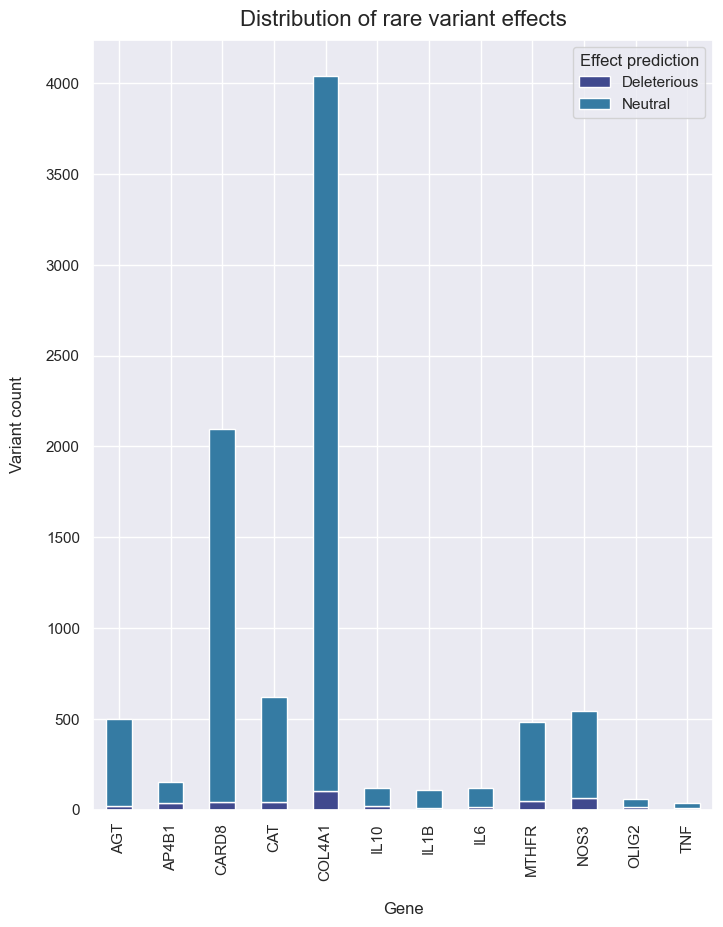

In [69]:
# Set figure size
sns.set(rc={"figure.figsize": (8, 10)})  # set plot size

# Set color palette
color_dict = dict({"Neutral": "#357BA3", "Deleterious": "#40498E"})


# Generate stacked barplot
pathogenicity_plot = functions.create_plot(
    data=pathogenicity_pivot,
    plot_type="stacked_barplot",
    palette=color_dict,
    legend_title="CADD prediction",
    legend_loc="upper right",
    x="GENE",
    horizontal_stack=False,
)

# Set labels
plt.xlabel(xlabel="Gene", labelpad=15)
plt.ylabel(ylabel="Variant count", labelpad=15)
plt.legend(title="Effect prediction", loc="upper right")
plt.title("Distribution of rare variant effects", size=constants.LARGEST_FONT, pad=10)

# Save figure
plt.savefig(

    "..\Results\Figures\4a-Rare_variant_effects.png", dpi=1200, bbox_inches="tight"
)

plt.show()

### Order variants based on level of potential harm

Order variants with deleterious predictions based on their level of potential harm, with those predicted to be the most deleterious by CADD Phred Score placed at the top of the table.

In [82]:
vep_scored = merged_data[
    [
        "GENE",
        "ID",
        "VAR_NAME",
        "CHROM",
        "POS",
        "REF",
        "ALT",
        "TYPE",
        "CADD_PHRED_SCORE",
        "CONSEQUENCE_CLASSIFICATION",
        "CONSEQUENCE",
        "IH_AF",
    ]
].sort_values(by=["CADD_PHRED_SCORE"], ascending=False)

vep_scored.head(5)

,GENE,ID,VAR_NAME,CHROM,POS,REF,ALT,TYPE,CADD_PHRED_SCORE,CONSEQUENCE_CLASSIFICATION,CONSEQUENCE,IH_AF
4160,AP4B1,113895105_A_C,chr1:113895105A-C,1,113895105,A,C,SNV,39.0,stop_gained,stop_gained,0.00082
4243,AP4B1,113901338_T_A,rs566041642,1,113901338,T,A,SNV,32.0,non_synonymous,missense,0.00082
285,COL4A1,110161349_G_A,rs539786257,13,110161349,G,A,SNV,32.0,non_synonymous,missense,0.00082
5017,NOS3,151001297_G_A,rs563793183,7,151001297,G,A,SNV,31.0,non_synonymous,missense,0.00082
4968,NOS3,150998961_G_A,rs552501121,7,150998961,G,A,SNV,30.0,non_synonymous,missense,0.00082


Save results

In [83]:
vep_scored.to_csv(
    os.path.join(
        PROJECT_ROOT,
        "Results",
        "Tables",
        "4a-Variant_impact.csv",
    ),
    index=False,
)